In [ ]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
# setting path
import os, sys
current_dir = os.path.abspath('')
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

In [ ]:
from config import SIMILARITY_PATH, EMBEDDING_PATH, PRETRAIN_OUTPUT_PATH
from source.emb_extr_res.emb_extr_res import get_embeddings_df, get_pairs_similarity_df, get_pretrain_agg_similarity
from source.load_data.wdc.load_wdc_dataset import EnglishDatasetLoader
from source.probing.brand_names import prepare_brands_list, brands_in_title_check, prepare_new_dataset, drop_brands
from source.probing.length import prepare_probing_len
from source.probing.words import words_in_title_check

In [ ]:
# paths to results
test_embeddings_path = path.join(EMBEDDING_PATH, r'test_embeddings.csv')
train_embeddings_path = path.join(EMBEDDING_PATH, r'train_embeddings.csv')

test_similarity_path = path.join(SIMILARITY_PATH, 'test_similarity.csv')
train_similarity_path = path.join(SIMILARITY_PATH, 'train_similarity.csv')

pretraining_output_path = path.join(PRETRAIN_OUTPUT_PATH, 'similarity_evaluation_test_evaluation_results.csv')

dataset_type = "cameras"
dataset_size = "medium"

In [ ]:
embedding_train_df = get_embeddings_df(train_embeddings_path)
embedding_train_df

In [ ]:
train_df = EnglishDatasetLoader.load_train(dataset_type, dataset_size)

In [ ]:
brands_to_drop = [',', 'd','memory',  'photo', 'co', 'usa',  'power',  'digital', 'camera', 'cam',  'hd',  'a',  'inc',  'le',  'film',  'case',  'pro', 'cameras']
brands = prepare_brands_list(train_df, brands_to_drop)

In [ ]:
train_df_left = train_df[["id_left", "title_left"]]
train_df_right = train_df[["id_right", "title_right"]]
train_df_left = train_df_left.drop_duplicates().rename({"id_left" : "id", "title_left" : "title"}, axis = 'columns')
train_df_right = train_df_right.drop_duplicates().rename({"id_right" : "id", "title_right" : "title"}, axis = 'columns')
df_train_all = pd.concat([train_df_right, train_df_left])
df_train_titles = df_train_all.groupby("id").first().reset_index()


In [ ]:
probing_df_chars, probing_df_words = prepare_probing_len(df_train_titles, train_embeddings_path)

In [ ]:
# probing_df_words.to_csv(r'probing_tasks\dataset\probing_df_words.csv')
# probing_df_chars.to_csv(r'probing_tasks\dataset\probing_df_chars.csv')

In [ ]:
new_dataset, ids_removed_brands = prepare_new_dataset(train_df, brands)

probing_task_df = new_dataset[new_dataset["changed"] == True].drop("changed", axis=1)
# probing_task_df.to_csv("datasets/df_removed_brands1.csv", index=False)

In [ ]:
key_words = ['camera', 'digital', 'len']
df_words = words_in_title_check(train_df, key_words)

In [ ]:
embedding_train_df_all = get_embeddings_df(train_embeddings_path)

probing_df_key_words = pd.merge(df_words[["id", "brand_in_title" ]], embedding_train_df_all, left_on = "id", right_on = 'id')
probing_df_key_words = probing_df_key_words.rename({"brand_in_title" : "label"}, axis=1)
probing_df_key_words = probing_df_key_words.drop("id", axis=1)

In [ ]:
# probing_df_key_words.to_csv(r'probing_tasks\dataset\probing_df_key_words.csv', index=False)

In [ ]:
brands_in_title_df = brands_in_title_check(new_dataset, brands)
deleted_ids = brands_in_title_df[brands_in_title_df["brand_in_title"]==True]["id"].values

embedding_train_df = get_embeddings_df(path.join(EMBEDDING_PATH, r'train_embeddings_removed_brands1.csv'))
embedding_train_df_all = get_embeddings_df(train_embeddings_path)

new_emb = embedding_train_df_all[~embedding_train_df_all["id"].isin(ids_removed_brands)] 
new_emb1 = embedding_train_df[embedding_train_df["id"].isin(ids_removed_brands)]
new = pd.concat([new_emb1, new_emb])
new["label"] = new["id"].isin(deleted_ids)



In [ ]:
# new.to_csv(r'probing_tasks\dataset\train_brand_names.csv', index=False)

# sentence length

In [ ]:
probing_df_words = pd.read_csv(r'probing_tasks\dataset\probing_df_words.csv')
probing_df_words = probing_df_words.drop(["Unnamed: 0", "id"], axis=1)

In [ ]:
probing_df_words_X, probing_df_words_y = probing_df_words.drop(["label"], axis=1), probing_df_words["label"]
X_train, X_test, y_train, y_test = train_test_split(probing_df_words_X, probing_df_words_y, test_size=0.15)

In [ ]:
clf = LogisticRegression(multi_class="multinomial", random_state=42, penalty = 'l1', solver="saga")

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy_score(y_true=y_test, y_pred=predictions)

In [ ]:
clf = RandomForestClassifier()

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy_score(y_true=y_test, y_pred=predictions)

In [ ]:
clf = XGBClassifier()

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy_score(y_true=y_test, y_pred=predictions)

In [ ]:

brand = [67, 64.6,  65.3]
brand_classsif = ["LogisticRegression", "RandomForest" ,"XGB"]

plt.bar(brand_classsif, brand, color = [(30/255, 57/255, 240/255, 0.70) , (30/255, 57/255, 240/255, 0.60), (30/255, 57/255, 240/255, 0.55)])
plt.ylim([0,100])
plt.ylabel("accuracy")

plt.show()

# brand

In [ ]:
probing_df_brands = pd.read_csv(r'probing_tasks\dataset\train_brand_names.csv')

In [ ]:
probing_df_brands = probing_df_brands.drop(["id"], axis=1)

X, y = probing_df_brands.drop(["label"], axis=1), probing_df_brands["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
clf = LogisticRegression(penalty="l1", solver="liblinear")

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy_score(y_true=y_test, y_pred=predictions)

In [ ]:
brand = [76.07, 72.00, 75.83]
brand_classsif = ["LogisticRegression", "RandomForest" ,"XGB"]


plt.bar(brand_classsif, brand, color = [(30/255, 57/255, 240/255) , (84/255, 117/255, 232/255), (68/255, 103/255, 227/255)])
plt.ylim([0,100])
plt.ylabel("accuracy")

plt.show()

In [ ]:
clf = RandomForestClassifier()

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy_score(y_true=y_test, y_pred=predictions)

In [ ]:
clf = XGBClassifier()

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy_score(y_true=y_test, y_pred=predictions)

In [ ]:
probing_df_key_words = probing_df_words = pd.read_csv(r'probing_tasks\dataset\probing_df_key_words.csv')
X, y = probing_df_key_words.drop(["label"], axis=1), probing_df_key_words["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
clf = LogisticRegression(penalty="l1", solver="liblinear")

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy_score(y_true=y_test, y_pred=predictions)

In [ ]:
clf = XGBClassifier()

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy_score(y_true=y_test, y_pred=predictions)

In [ ]:
clf = RandomForestClassifier()

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy_score(y_true=y_test, y_pred=predictions)

In [ ]:
brand = [82.29, 77.03, 79.66]
brand_classsif = ["LogisticRegression", "RandomForest" ,"XGB"]

plt.bar(brand_classsif, brand, color = [(30/255, 57/255, 240/255) , (84/255, 117/255, 232/255), (68/255, 103/255, 227/255)])
plt.ylim([0,100])
plt.ylabel("accuracy")

plt.show()

# Probing task: similarity

In [ ]:
from os import path
from config import TYPE, SIZE, EMBEDDING_PATH

from source.load_data.wdc.load_wdc_dataset import EnglishDatasetLoader
from source.utils.levenshtein_distance import compute_lev_dist_for_pairs
from source.emb_extr_res.emb_extr_res import get_embeddings_df
from source.utils.visualization import plot_histogram
from source.probing.similarity_pairs_probing.get_data import get_pair_similarity_probing_task_df

import pandas as pd
import numpy as np


### a) similarity of offers used in training (training set) 

Loading training dataset

In [ ]:
df_train = EnglishDatasetLoader.load_train(type=TYPE, size=SIZE)

Computing Levenshtein Distance for each pair - a new target variable for this probing task

In [ ]:
df_train['label'] = compute_lev_dist_for_pairs(df_train)

Choosing the best bins for discretization of the new target variable - similarity score of each pair

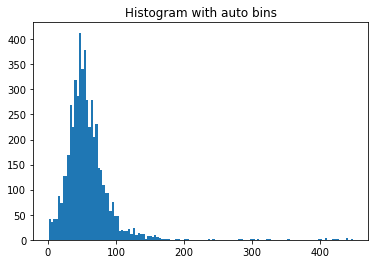

In [ ]:
plot_histogram(df_train['label'].values, bins='auto')

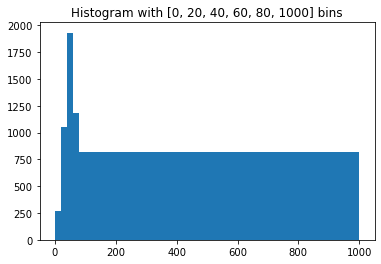

In [ ]:
bins = [0, 20, 40, 60, 80, 1000]
plot_histogram(df_train['label'].values, bins=bins)

Discretize the target variable

In [ ]:
df_train['label'] = pd.cut(x=df_train['label'], bins=bins, labels=[0, 1, 2, 3, 4])
df_train['label']

0       3
1       2
2       0
3       3
4       2
       ..
5250    2
5251    2
5252    1
5253    1
5254    2
Name: label, Length: 5255, dtype: category
Categories (5, int64): [0 < 1 < 2 < 3 < 4]

Get embeddings result data frame:

In [ ]:
train_embeddings_path = path.join(EMBEDDING_PATH, r'train_embeddings.csv')
embedding_train_df = get_embeddings_df(train_embeddings_path)

In [ ]:
train_dataset = get_pair_similarity_probing_task_df(df_train, embedding_train_df)

In [ ]:
train_dataset.head()

,label,left_id,left_0,left_1,left_2,left_3,left_4,left_5,left_6,left_7,...,right_758,right_759,right_760,right_761,right_762,right_763,right_764,right_765,right_766,right_767
0,3,12939297,-0.149791,1.071217,0.187230,-0.139591,-0.807871,-0.046871,-0.418031,-0.100208,...,0.797846,-0.080050,-0.185518,0.397698,-0.138480,-1.232638,-0.162692,0.073755,0.053071,-1.146569
2,2,17100990,-0.047905,1.216980,0.245378,-0.004205,-0.797601,0.002864,-0.316836,-0.107791,...,0.897925,-0.188297,-0.243057,0.478510,-0.081364,-1.289565,0.149673,0.150715,0.095488,-1.226075
3,1,17100990,-0.047905,1.216980,0.245378,-0.004205,-0.797601,0.002864,-0.316836,-0.107791,...,0.368393,0.189557,-0.478091,-0.293820,-0.887781,0.900259,0.227131,0.367114,0.561405,-0.056190
4,0,16638707,0.067015,-0.674859,0.512917,-0.328953,-0.683486,-0.473680,0.242210,-0.825564,...,0.368393,0.189557,-0.478091,-0.293820,-0.887781,0.900259,0.227131,0.367114,0.561405,-0.056190
5,4,8030713,-0.648637,-0.043288,0.583120,-0.672200,-0.752488,-0.265190,-0.026415,-0.275188,...,0.368393,0.189557,-0.478091,-0.293820,-0.887781,0.900259,0.227131,0.367114,0.561405,-0.056190


***


### b) similarity of offers not used in training (test set) 

Loading training dataset

In [ ]:
df_test = EnglishDatasetLoader.load_test(type=TYPE)

Computing Levenshtein Distance for each pair - a new target variable for this probing task

In [ ]:
df_test['label'] = compute_lev_dist_for_pairs(df_test)

Choosing the best bins for discretization of the new target variable - similarity score of each pair

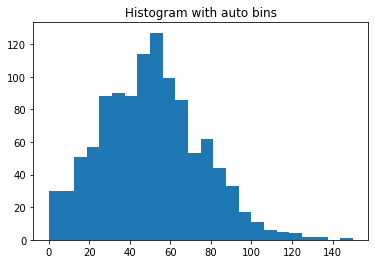

In [ ]:
plot_histogram(df_test['label'].values, bins='auto')

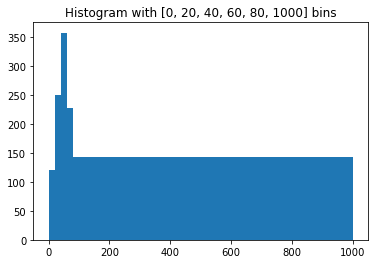

In [ ]:
bins = [0, 20, 40, 60, 80, 1000]
plot_histogram(df_test['label'].values, bins=bins)

Discretize the target variable

In [ ]:
df_test['label'] = pd.cut(x=df_test['label'], bins=bins, labels=[0, 1, 2, 3, 4])
df_test['label']

0       0
1       1
2       1
3       1
4       1
       ..
1095    2
1096    3
1097    3
1098    3
1099    1
Name: label, Length: 1100, dtype: category
Categories (5, int64): [0 < 1 < 2 < 3 < 4]

Get embeddings result data frame:

In [ ]:
test_embeddings_path = path.join(EMBEDDING_PATH, r'test_embeddings.csv')
embedding_test_df = get_embeddings_df(test_embeddings_path)

In [ ]:
test_dataset = get_pair_similarity_probing_task_df(df_test, embedding_test_df)
test_dataset.head()

,label,left_id,left_0,left_1,left_2,left_3,left_4,left_5,left_6,left_7,...,right_758,right_759,right_760,right_761,right_762,right_763,right_764,right_765,right_766,right_767
0,0,8571506,0.550398,-0.526154,0.082125,0.444099,0.053268,-0.345504,-0.084409,0.096725,...,0.300989,0.605257,-0.031447,0.055329,0.581134,-0.562669,-0.185219,-0.150309,0.547994,0.673631
2,1,8571506,0.550398,-0.526154,0.082125,0.444099,0.053268,-0.345504,-0.084409,0.096725,...,-0.567429,0.363189,-0.289208,-0.063081,-0.901390,-0.405271,0.049443,0.515929,-0.140260,-0.624937
3,1,8571506,0.550398,-0.526154,0.082125,0.444099,0.053268,-0.345504,-0.084409,0.096725,...,-1.015687,-0.076606,-0.227819,-0.420046,-0.208214,-0.679192,0.195318,-0.276532,-0.493191,-0.406144
4,1,11809928,-0.302815,-0.326458,-0.213350,0.392424,-0.177313,0.885198,0.045655,0.018103,...,-1.015687,-0.076606,-0.227819,-0.420046,-0.208214,-0.679192,0.195318,-0.276532,-0.493191,-0.406144
5,1,8571506,0.550398,-0.526154,0.082125,0.444099,0.053268,-0.345504,-0.084409,0.096725,...,0.367300,0.102650,-0.348079,-0.934553,-0.089702,-0.820126,0.130514,1.331819,0.021485,-0.814547


modeling 

In [ ]:
from source.utils.probing_tasks_utils import *

In [ ]:
test_dataset = test_dataset.drop(725, axis=0)

In [ ]:
clf = RandomForestClassifier()
pred_rf, acc_rf, f_score_rf = test_probing_task(train_dataset, test_dataset, clf)

Accuracy: 0.37522768670309653, f_score: 0.2937548397967106


In [ ]:
clf = LogisticRegression(
        multi_class="multinomial", random_state=42, penalty="l1", solver="saga"
    )
pred_lr, acc_lr, f_score_lr = test_probing_task(train_dataset, test_dataset, clf)

Accuracy: 0.33515482695810567, f_score: 0.1004092769440655


In [ ]:
clf = XGBClassifier()
pred_lr, acc_lr, f_score_lr = test_probing_task(train_dataset, test_dataset, clf)

Accuracy: 0.39617486338797814, f_score: 0.34009842724412576


# SIMILARITIES

In [ ]:
train_df = EnglishDatasetLoader.load_train(dataset_type, dataset_size)
res = train_df[["id_left", "id_right", "label"]]
res = res.rename({"id_left" : "left_id", "id_right":"right_id"}, axis = 1)

sim_train_df = get_pairs_similarity_df(train_similarity_path)
sim_train_df["right_id"] = pd.to_numeric(sim_train_df["right_id"])
sim_train_df["left_id"] = pd.to_numeric(sim_train_df["left_id"])
sim_df = pd.merge(res, sim_train_df, on =  ["left_id", "right_id"])

In [ ]:
sns.histplot(sim_df["cosine_score"][sim_df['label']==0], color = "blue", label = "label = 0")
sns.histplot(sim_df["cosine_score"][sim_df['label']==1], color = "orange", alpha = 0.5, label = "label = 1")
plt.legend()
plt.title("")
plt.show()